# Project idea for The Data Incubator: Sustainable recipe recommender

Created on Sun May  3 18:36:40 2020

@author: sbuergers@gmail.com

The majority of people on this planet are concerned with its future and the possibly catastrophic effects of global warming in both humanitarian and economic terms. While many people believe that eating food that is produced locally lowers their carbon footprint, research has shown that green house gas emissions due to food transport have very little overall impact.  

To assist people in shopping sustainably while at the same time cooking delicious food, I want to build a recipe recommendation engine that leverages publicly available ingredient lists for many recipes, and scientific findings on associated green house gas emissions. The goal is to suggest alternative recipes that are in line with users' tastes, but have a reduced carbon footprint to make for an easy change of cooking habits.  

In this notebook I am going to make some simple visualizations using Bokeh to illustrate the impact of different food items on global warming and how these products relate to the pool of recipes scraped from epicurious.com.

### Set up environment

In [7]:
# Data science libraries
import numpy as np
import pandas as pd 

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Change some defaults for visualizing data frames
pd.set_option("max_columns", 15)
pd.set_option("max_rows", 15)


Loading BokehJS ...

In [86]:
# Bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral


output_notebook()

Loading BokehJS ...

### Load data 
(I downloaded it from kaggle manually)

In [3]:
cd D:\\data science\nutrition

D:\data science\nutrition


In [4]:
# get recipes from csv file 
## Source: https://www.kaggle.com/hugodarwood/epirecipes
df_rec = pd.read_csv("epicurious_recipes_2017/epi_r.csv")

# kick out duplicate recipe names
df_rec.drop_duplicates(subset="title", inplace=True)
column_labels = list(df_rec.columns)


## save column labels to csv file, then manually go through and assign a label
## to each ingredient (where possible) that fits with the estimated green house
## gas emissions for a products life cycle from "our world in data"
## Source: https://ourworldindata.org/food-choice-vs-eating-local

#df = pd.DataFrame(column_labels, columns=["epicurious_labels"])
#df.to_csv('epicurious_ingredient_sustainability.csv', index=False)

## Read translation data back in after inputting labels manually
df_link = pd.read_csv('epicurious_ingredient_sustainability.csv')


## Read in look-up table for GHG emissions / sustainability
df_GHG = pd.read_csv('GHG-emissions-by-life-cycle-stage.csv')

### Explore green house gas (GHG) emissions data
for more details see https://ourworldindata.org/food-choice-vs-eating-local

__First plot using matplotlib__

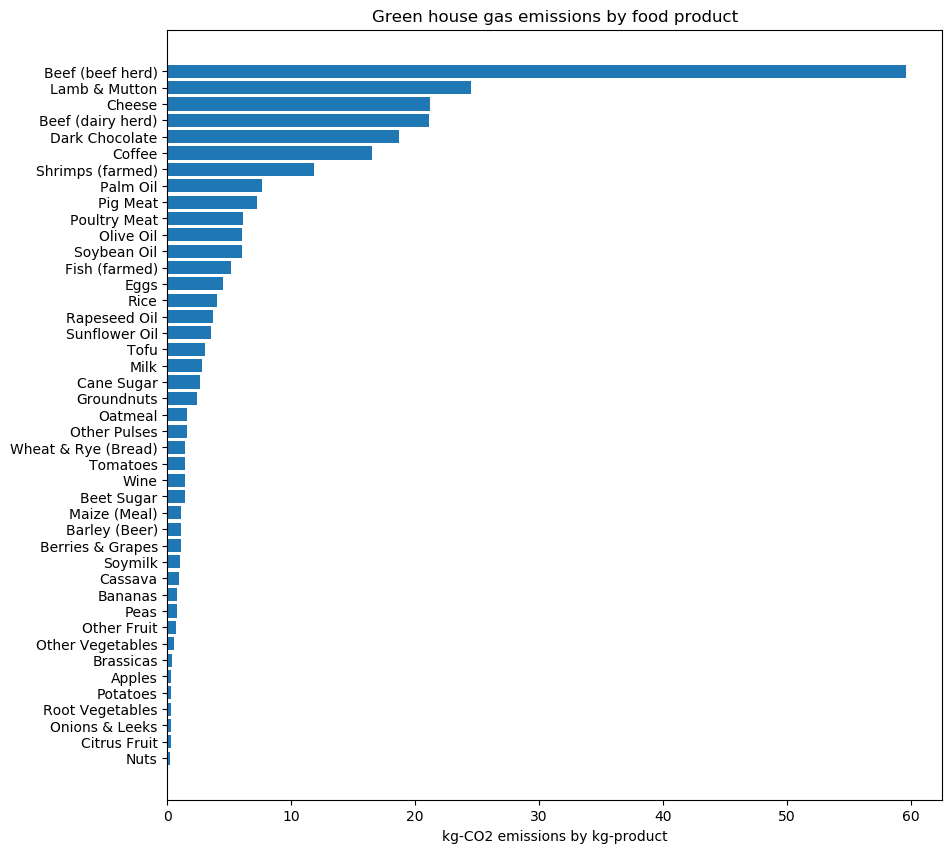

In [5]:
## Add total GHG emissions to table
df_GHG['total'] = df_GHG.loc[:,'Land use change':'Retail'].sum(axis=1)


## Visualize total GHG emissions
srtid = df_GHG['total'].sort_values().index
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(df_GHG['Food product'][srtid], df_GHG['total'][srtid], align='center')
ax.set_yticklabels(df_GHG['Food product'][srtid])
ax.set_xlabel('kg-CO2 emissions by kg-product')
ax.set_title('Green house gas emissions by food product')
plt.show()

__Now plot using Bokeh__

In [108]:
from bokeh.palettes import Category10
cols = Category10[len(life_cycle)]

# Show in order by total GHG emissions
df_GHG.sort_values(by='total', ascending=True, inplace=True)

# Define categories in Life cycle
life_cycle = df_GHG.columns[1:-1]

# Put data in dict format Bokeh understands
data = {'Food product' : df_GHG['Food product'],
        'Land use change' : df_GHG['Land use change'],
        'Animal Feed' : df_GHG['Animal Feed'],
        'Farm' : df_GHG['Farm'],
        'Processing' : df_GHG['Processing'],
        'Transport' : df_GHG['Transport'],
        'Packging' : df_GHG['Packging'],
        'Retail' : df_GHG['Retail']}

# Initialize figure
p = figure(y_range=df_GHG['Food product'], 
           plot_height=750, 
           plot_width=950, 
           x_range=(-5, 62), 
           title="Green house gas emissions by food product")

# Fill figure with data
p.hbar_stack(life_cycle, y='Food product', 
             height=0.9, 
             color=cols[0:len(life_cycle)], 
             source=ColumnDataSource(data), 
             legend_label=["%s" % x for x in life_cycle])

# Cosmetics and legend
p.xaxis.axis_label = "kg-CO2 emissions by kg-product"
p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "center_right"

# Show figure
show(p)

### Add GHG emissions data to recipe table

### (re-)load recipe data with GHG emission column

In [110]:
df_rec = pd.read_csv('epi_r_w_sust.csv')

### Visualize Carbon footprint of dishes (absolute)

__Using seaborn__

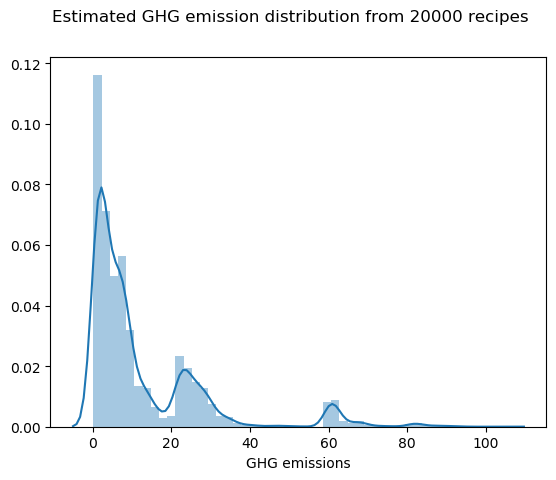

In [111]:
sns.distplot(df_rec['GHG emissions'].dropna())
plt.suptitle('Estimated GHG emission distribution from 20000 recipes');

__Using Bokeh__

In [115]:
# This is actually really cumbersome, and probably not worth the effort...

# get bin info from np.histogram
arr_hist, edges = np.histogram(df_rec['GHG emissions'].dropna(), 
                               bins = int(180/5), 
                               range = [0, 120])

# Put the information in a dataframe
ghg = pd.DataFrame({'em': arr_hist, 
                       'left': edges[:-1], 
                       'right': edges[1:]})

# Create the blank plot
p = figure(plot_height = 500, plot_width = 500, 
           title = 'Estimated GHG emission distribution from 20000 recipes',
          x_axis_label = 'GHG emissions', 
           y_axis_label = 'Recipe density')

# Add a quad glyph
p.quad(bottom=0, top=ghg['em'].dropna(),
       left=ghg['left'], right=ghg['right'], 
       fill_color='red', line_color='black')

# Show the plot
show(p)

### Explore relationship between number of ingredients and GHG emissions

SpearmanrResult(correlation=0.4991671403720115, pvalue=0.0)

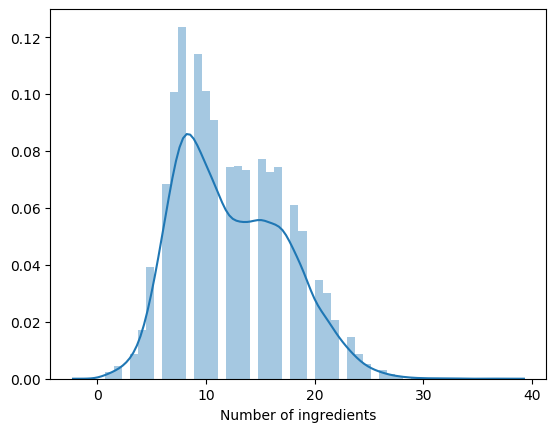

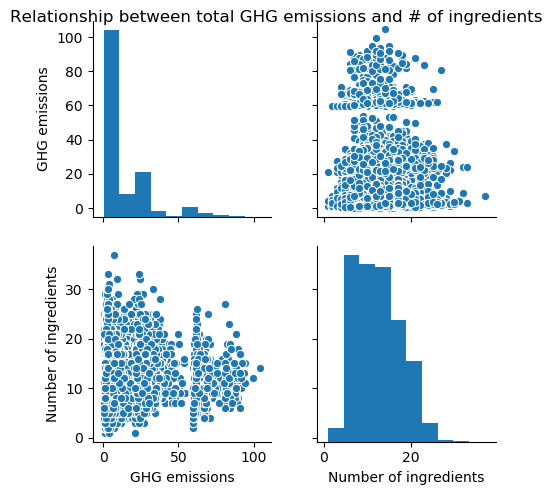

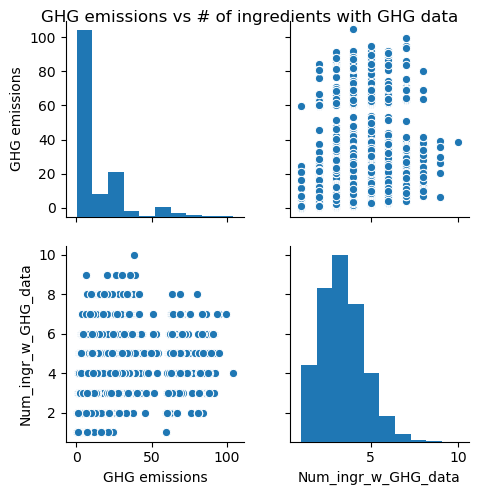

In [8]:
## There appear to be three clusters of Low, intermediate and high GHG output.
## Does this have to do with the number of overall ingredients? 
sns.distplot(df_rec['Number of ingredients'].dropna())

## Clearly not! Another way of looking at this:
df = df_rec.loc[:,['GHG emissions', 'Number of ingredients']].dropna()
sns.pairplot(df);
plt.suptitle('Relationship between total GHG emissions and # of ingredients');

## Surprisingly there does not seem to be much of a relationship between 
## number of ingredients and total GHG emissions, to quantify let's also do
## some statistics
import scipy
rho = scipy.stats.spearmanr(df['Number of ingredients'], df['GHG emissions'])
rho

# So statistically there definitely is a relationship, but its effect size is
# surprisingly small (Rho = 0.095)


## This relationship should be more pronounced when I consider the number
## of ingredients with an emission value
df = df_rec.loc[:,['GHG emissions', 'Num_ingr_w_GHG_data']].dropna()
sns.pairplot(df);
plt.suptitle('GHG emissions vs # of ingredients with GHG data');
rho2 = scipy.stats.spearmanr(df['Num_ingr_w_GHG_data'], df['GHG emissions'])
rho2

## As expected, this gives a much larger correlation (rho=0.48)
## Hence, there is definitely a strong incentive to make sure that most 
## ingredients can be assigned a GHG emission value, otherwise results will be
## biased. 

### Example recipes with different degrees of sustainability

In [10]:
# create group vector (0 = low, 1 = medium, 2 = high)
GHG_group = np.zeros(df_rec.shape[0])
GHG_group[df_rec['GHG emissions'].between(19.001,39)] = 1
GHG_group[df_rec['GHG emissions'].between(39.001,df_rec['GHG emissions'].max())] = 2
df_rec['GHG group'] = GHG_group 


## Show 10 recipes for each subgroup
print(' ')
print('Sustainable:')
print(df_rec['title'][df_rec['GHG group'] == 0][0:10])
print(' ')
print('Not sustainable:')
print(df_rec['title'][df_rec['GHG group'] == 1][0:10])
print(' ')
print('Absolutely not sustainable:')
print(df_rec['title'][df_rec['GHG group'] == 2][0:10])

 
Sustainable:
0                       Lentil, Apple, and Turkey Wrap 
1           Boudin Blanc Terrine with Red Onion Confit 
2                         Potato and Fennel Soup Hodge 
3                      Mahi-Mahi in Tomato Olive Sauce 
5                                        The Best Blts 
6     Ham and Spring Vegetable Salad with Shallot Vi...
7                                 Spicy-Sweet Kumquats 
9     Ham Persillade with Mustard Potato Salad and M...
10        Yams Braised with Cream, Rosemary and Nutmeg 
12    Banana-Chocolate Chip Cake With Peanut Butter ...
Name: title, dtype: object
 
Not sustainable:
4                             Spinach Noodle Casserole 
11                                   Spicy Noodle Soup 
18    Mozzarella-Topped Peppers with Tomatoes and Ga...
23          Pancetta and Taleggio Lasagna with Treviso 
34                    Fontina Mac with Squash and Sage 
47                 Herbed Goat Cheese Spread with Mint 
60                          Pecan Blue Chee

### Do all recipes with high green house gas emissions contain beef?
No, but more than 90 percent do.

In [11]:
beef_idx = df_link['sustainability_labels'] == 'Beef (beef herd)'
df_rec['contains beef'] = df_rec.iloc[:,0:(len(beef_idx))].loc[:,beef_idx.values].any(axis=1)

sum(df_rec['contains beef'] & (df_rec['GHG group'] == 2)) / sum(df_rec['GHG group'] == 2)

0.9279538904899135

### What are the best and worst 10 recipes for GHG emissions?

In [12]:
GHG_sort_idx = df_rec.dropna().sort_values(by='GHG emissions').index
sust_rec = df_rec.iloc[GHG_sort_idx[0:10],:]
unsust_rec = df_rec.iloc[GHG_sort_idx[-10:],:]
print(' ')
print('Most sustainable recipes:')
print(sust_rec['title'])
print(' ')
print('Least sustainable recipes:')
print(unsust_rec['title'])

 
Most sustainable recipes:
1884                          Date-Pecan Bourbon Truffles 
13355                               Chocolate Nut Cookies 
11611    Chocolate Chip-Macadamia Nut Bars with Shortbr...
12372                                    Pine Nut Tassies 
8749                                 Spicy Toasted Pecans 
11599                             Mexican Chocolate Torte 
10539                                    Caramel-Nut Tart 
1454                               Chocolate Fudge-Almond 
14629                                   Roasted Chestnuts 
5094                    Pistachio Cardamom Butter Cookies 
Name: title, dtype: object
 
Least sustainable recipes:
17603                     Pasta, Sausage, and Bean Ragoût 
17508           Three-Cheese Lasagna with Italian Sausage 
7413                      Braised Lamb Shanks with Prunes 
8781                              Kentucky Bourbon Burgoo 
10012                                    Grilled Sausages 
5436                         Sp

## Build a recommender system that suggests similar food choices, but more sustainable! 

For this I want to find some users of epicurious recipes using twitter.
I will simply assume that if somebody tweets a recipe, they also like it.

In [13]:
## Twitter 
import GetOldTweets3 as got

## Make python wait for twitter server 
import time

## Look for users who post recipes from epicurious on Twitter
This is quite time consuming, because the server does not accept additional requests for a few minutes after the limit is reached. For illustration purposes I selected a subset of recipes (< 100). 

In [23]:
## Search for recipe names and 'epicurious'
## Runs into rate limit fairly quickly (after around 300 recipes)
## To simplify only look for recipes with a rating > 4 and take periodic breaks
df_rec_high_rated = df_rec.loc[df_rec['rating'] > 4,:]
user_dict = {}
cnt = 0
for i, title in enumerate(df_rec_high_rated['title'][1943:2144]):
    cnt = cnt + 1
    ## take a 5 minutes break from spamming the twitter server every 300 titles
    if cnt > 300:
        time.sleep(600)
        cnt = 0
    if i % 100 == 0:
        print(i, title)
    search_words = title + ' #epicurious'
    max_tweets = 100
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(search_words)\
        .setSince("2010-01-01")\
        .setUntil("2020-05-05")\
        .setMaxTweets(max_tweets)
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    ## if tweets is not empty, add users with title to dictionary
    if tweets:
        print(i, title, ': Tweet found!!!')
        for j, tweet in enumerate(tweets):
            user = tweet.username
            if user in user_dict:
                user_dict[user].add(title)
            else:
                user_dict[user] = set([title])

0 Top Sirloin Steak with Bell Pepper and Onion Sauté 
23 White Chicken Chili  : Tweet found!!!
29 Chimichurri  : Tweet found!!!
38 Winter Salad with Lemon-Yogurt Dressing  : Tweet found!!!
50 Pie Crust  : Tweet found!!!
59 Lamb Sausage Patties with Fresh Mint, Feta, and Garlic  : Tweet found!!!
76 Buffalo Burgers with Pickled Onions and Smoky Red Pepper Sauce  : Tweet found!!!
89 Quinoa with Moroccan Winter Squash and Carrot Stew  : Tweet found!!!
100 Broiled Duck Breasts with Orange Chipotle Sauce 
105 Fish Tagine with Tomatoes, Capers, and Cinnamon  : Tweet found!!!
114 Chocolate Chip Oatmeal Cookies  : Tweet found!!!
117 Gnocchi  : Tweet found!!!
170 Swiss Chard, Raisin, and Pine Nut Tart  : Tweet found!!!
172 Salmon and Rice Wrapped in Pastry with Dill Sauce  : Tweet found!!!
190 Brunswick Stew  : Tweet found!!!
198 Beurre Blanc  : Tweet found!!!
200 Apple and Persimmon Tarte Tatin 


Using my make-shift user dictionary I can now create a matrix of users x recipes and use it for my recommender

In [ ]:
user_keys = user_dict.keys()
titles = list(df_rec['title'].values)
usermat = np.zeros((len(user_keys), len(titles)))
df_users = pd.DataFrame(usermat, columns = titles, index=user_keys)
for i, user in enumerate(user_keys):
    match_ids = [j for j, val in enumerate(titles) if val in user_dict[user]] 
    df_users.iloc[i, match_ids] = 1
    
print('Number of users after 200 recipes: ', len(user_keys))

## Save to file 
df_users.to_csv('epi_users.csv')

Load user-recipe table created from tweets

In [23]:
df_users = pd.read_csv('epi_users.csv', index_col=0)

In [25]:
df_users.head()

Lentil, Apple, and Turkey Wrap   \
Susanna43b                                  0.0   
the_epicurious                              0.0   
jewelosco                                   0.0   
eduCatalysis                                0.0   
epicurious                                  0.0   

                Boudin Blanc Terrine with Red Onion Confit   \
Susanna43b                                              0.0   
the_epicurious                                          0.0   
jewelosco                                               0.0   
eduCatalysis                                            0.0   
epicurious                                              0.0   

                Potato and Fennel Soup Hodge   \
Susanna43b                                0.0   
the_epicurious                            0.0   
jewelosco                                 0.0   
eduCatalysis                              0.0   
epicurious                                0.0   

                Mahi-Mahi in Tomato Olive Sauce   Spinach Noodle Casserole   \
Susanna43b                                   1.0                        0.0   
the_epicurious                               0.0                        0.0   
jewelosco                                    0.0                        0.0   
eduCatalysis                                 0.0                        0.0   
epicurious                                   0.0                        0.0   

                The Best Blts   \
Susanna43b                 0.0   
the_epicurious             0.0   
jewelosco                  0.0   
eduCatalysis               0.0   
epicurious                 0.0   

                Ham and Spring Vegetable Salad with Shallot Vinaigrette   ...  \
Susanna43b                                                    0.0         ...   
the_epicurious                                                0.0         ...   
jewelosco                                                     0.0         ...   
eduCatalysis                                                  0.0         ...   
epicurious                                                    0.0         ...   

                Crispy Salt and Pepper Chicken with Caramelized Fennel and Shallots   \
Susanna43b                                                    0.0                      
the_epicurious                                                0.0                      
jewelosco                                                     0.0                      
eduCatalysis                                                  0.0                      
epicurious                                                    0.0                      

                Orange-Tini   Chinese Barbecued Spareribs   \
Susanna43b               0.0                           0.0   
the_epicurious           0.0                           0.0   
jewelosco                0.0                           0.0   
eduCatalysis             0.0                           0.0   
epicurious               0.0                           0.0   

                Artichoke and Parmesan Risotto   Turkey Cream Puff Pie   \
Susanna43b                                  0.0                     0.0   
the_epicurious                              0.0                     0.0   
jewelosco                                   0.0                     0.0   
eduCatalysis                                0.0                     0.0   
epicurious                                  0.0                     0.0   

                Snapper on Angel Hair with Citrus Cream   \
Susanna43b                                           0.0   
the_epicurious                                       0.0   
jewelosco                                            0.0   
eduCatalysis                                         0.0   
epicurious                                           0.0   

                Baked Ham with Marmalade-Horseradish Glaze   
Susanna43b                                              0.0  
the_epicurious                

Plot distribution of number of recipes per user

### What recipe titles are tweeted about by most users?

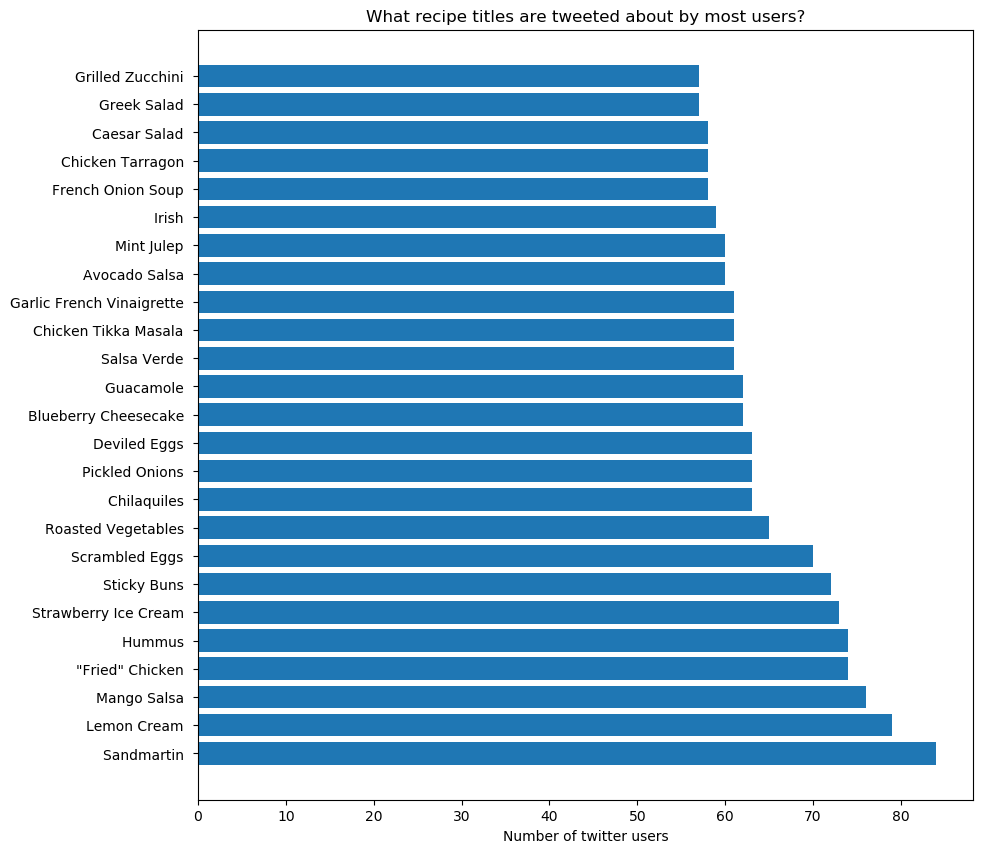

In [34]:
titles = df_users.columns
recipe_tweetnum = df_users.sum(axis=0).values
srtid = np.flip(np.argsort(recipe_tweetnum).astype(int))
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(np.asarray(titles)[srtid][0:25], recipe_tweetnum[srtid][0:25], align='center')
ax.set_xlabel('Number of twitter users')
ax.set_title('What recipe titles are tweeted about by most users?')
plt.show()

## Future directions:
Parentheses indicate optional or later steps  
1. Improve twitter user search  
     * Avoid single common word recipe names  
     * Try looking for urls of recipes specifically  
     * (Maybe even try to assign sentiment to tweets) 
2. Build recommender system  
    * User-based collabroative filtering  
    * Item-based collaborative filtering  
    * (Once the collab. filt. works, try neural networks)  
3. More and better data  
    * Get more recipe data   
    * Improve on dummy coding - include quantities of ingredients  
    * Improve on GHG emissions labels for ingredients (possible to find additional, complementary sources?)  

### 2. Build recommender system
For now I just want to get code that runs, I can augment and improve the data later

In [44]:
df_users.head(10)

Lentil, Apple, and Turkey Wrap   \
Susanna43b                                   0.0   
the_epicurious                               0.0   
jewelosco                                    0.0   
eduCatalysis                                 0.0   
epicurious                                   0.0   
SueScoby                                     0.0   
mindystan                                    0.0   
FoodologieKarla                              0.0   
01MB                                         0.0   
beathirstygirl                               0.0   

                 Boudin Blanc Terrine with Red Onion Confit   \
Susanna43b                                               0.0   
the_epicurious                                           0.0   
jewelosco                                                0.0   
eduCatalysis                                             0.0   
epicurious                                               0.0   
SueScoby                                                 0.0   
mindystan                                                0.0   
FoodologieKarla                                          0.0   
01MB                                                     0.0   
beathirstygirl                                           0.0   

                 Potato and Fennel Soup Hodge   \
Susanna43b                                 0.0   
the_epicurious                             0.0   
jewelosco                                  0.0   
eduCatalysis                               0.0   
epicurious                                 0.0   
SueScoby                                   0.0   
mindystan                                  0.0   
FoodologieKarla                            0.0   
01MB                                       0.0   
beathirstygirl                             0.0   

                 Mahi-Mahi in Tomato Olive Sauce   Spinach Noodle Casserole   \
Susanna43b                                    1.0                        0.0   
the_epicurious                                0.0                        0.0   
jewelosco                                     0.0                        0.0   
eduCatalysis                                  0.0                        0.0   
epicurious                                    0.0                        0.0   
SueScoby                                      0.0                        0.0   
mindystan                                     0.0                        0.0   
FoodologieKarla                               0.0                        0.0   
01MB                                          0.0                        0.0   
beathirstygirl                                0.0                        0.0   

                 The Best Blts   \
Susanna43b                  0.0   
the_epicurious              0.0   
jewelosco                   0.0   
eduCatalysis                0.0   
epicurious                  0.0   
SueScoby                    0.0   
mindystan                   0.0   
FoodologieKarla             0.0   
01MB                        0.0   
beathirstygirl              0.0   

                 Ham and Spring Vegetable Salad with Shallot Vinaigrette   \
Susanna43b                                                     0.0          
the_epicurious                                                 0.0          
jewelosco                                                      0.0          
eduCatalysis                                                   0.0          
epicurious                                                     0.0          
SueScoby                                                       0.0          
mindystan                                                      0.0          
FoodologieKarla                                                0.0          
01MB                                                           0.0          
beathirstygirl                                                 0.0          

                 ...  \
Susanna43b       ...   
the_epicurious   ...   
j

In [46]:
df_users.loc['Susanna43b',:].sum()
## This User has tweeted about 55 recipes, that is quite a lot. So we can use her as a simple test case
## We will leave out half the recipes when making our recommendation and then check how close we came to recommending them. 

55.0

In [ ]:
## Let's see if we can find a good novel recipe suggestion for her. 
##
## Follow tutorial from: 
## https://realpython.com/build-recommendation-engine-collaborative-filtering/

In [48]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans

In [ ]:
## Put data into surprise format
reader = Reader(rating_scale=(1))

# Loads Pandas dataframe
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)

In [49]:
## Use KNN to find similar users
# with item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [ ]:
## Fit model to training set
trainingSet = data.build_full_trainset()

algo.fit(trainingSet)

prediction = algo.predict('E', 2)
prediction.est